Boiler plate

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns


Data Preprocessing

In [ ]:
df = pd.read_csv("/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", low_memory=False)
print("Initial shape:", df.shape)

Initial shape: (286467, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286462,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286463,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286464,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286465,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df.drop(columns=[
    'Flow ID', 'Source IP', 'Source Port', 'Destination IP',
    'Destination Port', 'Protocol', 'Timestamp'
], inplace=True, errors='ignore')


In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("After cleaning shape:", df.shape)

After cleaning shape: (286096, 79)


In [ ]:
df.columns = df.columns.str.strip()
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [ ]:
X = df.drop('Label', axis=1).select_dtypes(include=[np.number])
y = df['Label'].values

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y[X.index]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
def create_sequences(X, y, seq_len=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, seq_len=10)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)


X_seq shape: (286086, 10, 78)
y_seq shape: (286086,)


Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

LSTM model Build

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        36,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,673 (143.25 KB)

 Trainable params: 36,673 (143.25 KB)

 Non-trainable params: 0 (0.00 B)

Model Training

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64
)

Epoch 1/10
3577/3577 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9800 - loss: 0.0619 - val_accuracy: 0.9970 - val_loss: 0.0107
Epoch 2/10
3577/3577 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.9971 - loss: 0.0100 - val_accuracy: 0.9979 - val_loss: 0.0075
Epoch 3/10
3577/3577 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.9981 - loss: 0.0070 - val_accuracy: 0.9985 - val_loss: 0.0063
Epoch 4/10
3577/3577 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.9984 - loss: 0.0058 - val_accuracy: 0.9987 - val_loss: 0.0058
Epoch 5/10
3577/3577 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9986 - loss: 0.0059 - val_accuracy: 0.9985 - val_loss: 0.0054
Epoch 6/10
3577/3577 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9990 - val_loss: 0.0047
Epoch 7/10
3577/3577 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.9990 - loss: 0.0041 - val_accuracy: 0.9990 - val_loss: 0.0046
Epoch 8/10
3577/3577 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.9991 -

Model Evaluation

In [ ]:
# Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred)

# Print Metrics
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

1789/1789 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Accuracy: 0.9990
F1 Score: 0.9991
Recall: 0.9993
ROC-AUC: 0.9999


Confusion Matrix

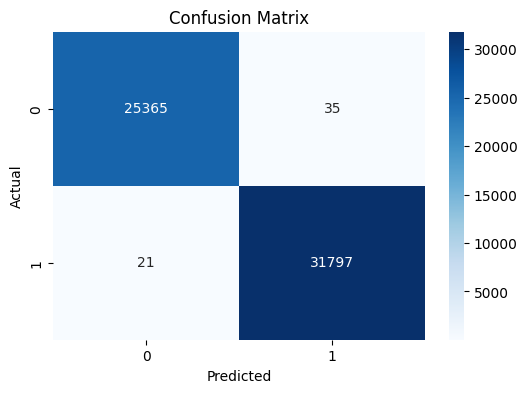

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()